# Local Average Treatment Effect (LATE) Estimation using a Bayesian Potential Outcomes Approach

## Background

At a fundamental level, there three causal estimation frameworks:
1. **Econometric Causality**, based on the structural equation model (SEM)
2. **Inferred Causation**, based on causal graphs, counterfactuals and SEM (more philosophical)
3. **Potential Outcomes**, based on hypothetical control behaviour of every individual without the intervention (from bio-statistics)

Here, we use the **Pontential Outcomes** causal framework, where we write everything in terms of:
* Treatments (treatment/control)
* Inviduals potential outcomes

At high-level, analyzing the causal effects of any intervention becomes a two-step process:
1. Set up the inference problem (joint distribution) that reflects the data generation and assumptions required to find an unbiased causal metric
2. Inference problem where the random variables of the joint distribution are fitted

## Causal Effect Estimation with Partial Compliance

In a randomized experiment, when the user exposure indicator is not completely controllable, the probability of receiving the treatment is difficult to replicate in both treatment and control groups. This type of experiments are known as experiment with **non-compliance** or **imperfect experiments**. 

In this setting, users in control are prevented from being treated, and users in treatment are assigned to get the treatment. What is controllable here is the **__intention to treat__** users for both groups. However, for uncontrollable reasons, only a proportion of users in treatment are actually treated, and in control either a group of people get a placebo treatment, or nobody gets any treatment at all.

For the case of ad campaign evaluation, we control user randomization, but we do not control who is exposed to the ad in the end. That is because we can not control directly the user bidding process. Thus the setting we have is

1. Users assigned to control and their conversions
2. Users assigned to treatment who did not see the ad and their conversions
3. Users assigned to treatment who see the ad and their conversions

The goal is to find the campaign effect on the __exposed__ or __targeted__ population assuming no effect on the users who do not see the ad. This effect is often referred as the **Local Average Treatment Effect** (LATE) or as **Complier Average Causal Effect** (CACE). 

## The method Implemented Here

Here, the goal is to replicate the results of the campaign effectiveness experiment [here](http://alumni.soe.ucsc.edu/~jbarajas/publications/paper_MarketingScience.pdf), which uses the Bayesian causal effect estimation for non-compliance problems described [here](https://scholar.harvard.edu/files/imbens/files/bayesian_inference_for_causal_effects_in_randomized_experiments_with_noncompliance.pdf). We find the overall campaign effect, i.e. the intention-to-treat __ITT__ effect and __LATE__ with a Bayesian approach to provide confidence intervals based on the posterior credible intervals.

These estimations are helpful to identify the conditions necessary to achieve statistical significant results for a minimum detectable lift in a power analysis.

<img src="attachment:image.png" width="500">

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Data input format (all user counts):
# input = [N_{{0,1}C}^0,    - Control non-converters
#          N_{{0,1}C}^1,    - Control converter
#          N_{0S}^0,        - Treatment, no ad exposure, non-converter
#          N_{0S}^1,        - Treatment, no ad exposure, converter
#          N_{1S}^0,        - Treatment, ad exposure, non-converter
#          N_{1S}^1,        - Treatment, ad exposure, converter
#          ]

First, a point estimate for all probabilities based on a method of moments

In [2]:
# Method of moments for probabilities that we know
def point_init(in_counts):
    p0_d0 = in_counts[3] / sum(in_counts[2:3])
    p1_d1 = in_counts[5] / sum(in_counts[4:5])
    pd = sum(in_counts[4:5]) / sum(in_counts[2:5])

    p0_camp = in_counts[1] / sum(in_counts[0:1])
    p1_camp = (in_counts[3] + in_counts[5]) / sum(in_counts[2:5])
    p0_d1 = (p0_camp - p0_d0 * (1 - pd)) / pd
    return p1_d1, p0_d1, p0_d0, pd, p0_camp, p1_camp

The following function (not used here) is a point estimate for the LATE effects

In [3]:
# Late Method of moments assuming the mixture of potentially exposed users (exposed if assigned) or compliers
# and never-exposed users or defiers in CACE notation
# See Bayesian Data Analysis Gelman page 224
# or Appendix C http://alumni.soe.ucsc.edu/~jbarajas/publications/paper_MarketingScience.pdf
def pointEst(in_counts):
    [p1_d1, p0_d1, p0_d0, pd, p0_camp, p1_camp] = point_init(in_counts)
    late = p1_d1 - p0_d1
    late_lift = (p1_d1 - p0_d1) / p0_d1
    itt = p1_camp - p0_camp
    return late, late_lift, pd, itt

The following function is the actual LATE estimations with MCMC sampling. 

* Bernoulli likelihoods are assumed for the conversion indicators and the user selection for ad exposure
* Beta conjugate priors are assumed for the Bernoulli likelihood parameters
* It requires: 

    * __in_counts__: the user counts  as described above
    * __N_burnin, N_samples__: burn-in and actual number of samples
    * __alpha_0, beta_0__: prior parameters for the Beta distributions 

In [4]:
def mcmcEst(in_counts, N_burnin, N_samples, alpha_0, beta_0):
    # Initialize with point estimate
    [theta_d1, theta_d0, theta_n, p_sel, p0_camp, p1_camp] = point_init(in_counts)

    # Initialization of exposed label for control
    N_d1 = sum(in_counts[4:5])
    N_n1 = sum(in_counts[2:3])
    N_n1_Conv = in_counts[3]
    N_n1_nConv = in_counts[2]

    # Probability of p_sel in control (exposed-if-assigned users)
    Pd_d0_Conv = p_sel * theta_d0 / (p_sel * theta_d0 + (1 - p_sel) * theta_n)
    Pd_d0_nConv = p_sel * (1 - theta_d0) / (p_sel * (1 - theta_d0) + (1 - p_sel) * (1 - theta_n))

    # Sampling counts in control (# of those who would have seen exposed in treatment but are in control)
    N_d0_Conv = np.random.binomial(n=in_counts[1], p=Pd_d0_Conv)
    N_d0_nConv = np.random.binomial(n=in_counts[0], p=Pd_d0_nConv)
    N_n0_Conv = in_counts[1] - N_d0_Conv
    N_n0_nConv = in_counts[0] - N_d0_nConv

    # Just screen printing purposes
    prop = 0.5
    k = 1

    # ----------Burn in iterations ----------------------------
    for s in range(N_burnin):
        if s >= round(prop * k * N_burnin):
            k += 1
            print(s)

        # Beta posterior distribution and sampling for p_sel
        # p_sel = prob of qualified P(D=1)
        alpha_p_sel = alpha_0 + N_d1 + N_d0_Conv + N_d0_nConv
        beta_p_sel = beta_0 + N_n1 + N_n0_Conv + N_n0_nConv
        p_sel = np.random.beta(a=alpha_p_sel, b=beta_p_sel)

        # Beta posterior distribution and sampling for theta_d1
        # theta_d1 = P(Y=1|D=1,Z=1) -- Fixed during the iterations
        alpha_d1 = alpha_0 + in_counts[5]
        beta_d1 = beta_0 + in_counts[4]
        theta_d1 = np.random.beta(a=alpha_d1, b=beta_d1)

        # Beta posterior distribution and sampling for theta_d0
        # theta_d0 = P(Y=1 | D = 1, Z = 0)
        alpha_d0 = alpha_0 + N_d0_Conv
        beta_d0 = beta_0 + N_d0_nConv
        theta_d0 = np.random.beta(a=alpha_d0, b=beta_d0)

        # Beta posterior distribution and sampling for theta_n
        # theta_n = P(Y=1|D=0,Z=0) = P(Y=1|D=0,Z=1) = P(Y=1|D=0)
        alpha_n = alpha_0 + N_n0_Conv + N_n1_Conv
        beta_n = beta_0 + N_n0_nConv + N_n1_nConv
        theta_n = np.random.beta(a=alpha_n, b=beta_n)

        # Finding probabilities of converter/non-converters and exposed-if-assigned users in control
        Pd_d0_Conv = p_sel * theta_d0 / (p_sel * theta_d0 + (1 - p_sel) * theta_n)
        Pd_d0_nConv = p_sel * (1 - theta_d0) / (p_sel * (1 - theta_d0) + (1 - p_sel) * (1 - theta_n))

        # Sampling the unobserved user counts in control
        N_d0_Conv = np.random.binomial(n=in_counts[1], p=Pd_d0_Conv)
        N_d0_nConv = np.random.binomial(n=in_counts[0], p=Pd_d0_nConv)
        N_n0_Conv = in_counts[1] - N_d0_Conv
        N_n0_nConv = in_counts[0] - N_d0_nConv

    # Actual samples after burnin
    p_sel_samples = np.zeros(N_samples)
    theta_d1_samples = np.zeros(N_samples)
    theta_d0_samples = np.zeros(N_samples)
    theta_n_samples = np.zeros(N_samples)

    prop = 0.5
    k = 1

    for s in range(N_samples):
        if s >= round(prop * k * N_samples):
            k += 1
            print(s)

        # Beta posterior distribution and sampling for p_sel
        # p_sel = prob of qualified P(D=1)
        alpha_p_sel = alpha_0 + N_d1 + N_d0_Conv + N_d0_nConv
        beta_p_sel = beta_0 + N_n1 + N_n0_Conv + N_n0_nConv
        p_sel = np.random.beta(a=alpha_p_sel, b=beta_p_sel)

        # Beta posterior distribution and sampling for theta_d1
        # theta_d1 = P(Y=1|D=1,Z=1) -- Fixed during the iterations
        alpha_d1 = alpha_0 + in_counts[5]
        beta_d1 = beta_0 + in_counts[4]
        theta_d1 = np.random.beta(a=alpha_d1, b=beta_d1)

        # Beta posterior distribution and sampling for theta_d0
        # theta_d0 = P(Y=1 | D = 1, Z = 0)
        alpha_d0 = alpha_0 + N_d0_Conv
        beta_d0 = beta_0 + N_d0_nConv
        theta_d0 = np.random.beta(a=alpha_d0, b=beta_d0)

        # Beta posterior distribution and sampling for theta_n
        # theta_n = P(Y=1|D=0,Z=0) = P(Y=1|D=0,Z=1) = P(Y=1|D=0)
        alpha_n = alpha_0 + N_n0_Conv + N_n1_Conv
        beta_n = beta_0 + N_n0_nConv + N_n1_nConv
        theta_n = np.random.beta(a=alpha_n, b=beta_n)

        # Finding probabilities of converter/non-converters and exposed-if-assigned users in control
        Pd_d0_Conv = p_sel * theta_d0 / (p_sel * theta_d0 + (1 - p_sel) * theta_n)
        Pd_d0_nConv = p_sel * (1 - theta_d0) / (p_sel * (1 - theta_d0) + (1 - p_sel) * (1 - theta_n))

        # Sampling the unobserved user counts in control
        N_d0_Conv = np.random.binomial(n=in_counts[1], p=Pd_d0_Conv)
        N_d0_nConv = np.random.binomial(n=in_counts[0], p=Pd_d0_nConv)
        N_n0_Conv = in_counts[1] - N_d0_Conv
        N_n0_nConv = in_counts[0] - N_d0_nConv

        p_sel_samples[s] = p_sel
        theta_d1_samples[s] = theta_d1
        theta_d0_samples[s] = theta_d0
        theta_n_samples[s] = theta_n

    return theta_d1_samples, theta_d0_samples, theta_n_samples, p_sel_samples


Running example with data from the [paper](http://alumni.soe.ucsc.edu/~jbarajas/publications/paper_MarketingScience.pdf)

In [5]:
# Data input format (all user counts):
# input = [N_{{0,1}C}^0,    - Control non-converters
#          N_{{0,1}C}^1,    - Control converter
#          N_{0S}^0,        - Treatment, no ad exposure, non-converter
#          N_{0S}^1,        - Treatment, no ad exposure, converter
#          N_{1S}^0,        - Treatment, ad exposure, non-converter
#          N_{1S}^1,        - Treatment, ad exposure, converter
#          ]

# Data sample
in_counts = [1560146, 400, 12010058, 2387, 5708558, 2599]
# priors
alpha_0 = 0.50
beta_0 = 0.50
# Iterations
# N_burnin, N_samples
N_burnin = 10000
N_samples = 100000

[theta_d1_samples, theta_d0_samples, theta_n_samples, p_sel_samples] = mcmcEst(in_counts, N_burnin, N_samples, alpha_0, beta_0)
print('Prob of Conversion Treatment and Exposed (samples) = ', theta_d1_samples)
print('Prob of Conversion Treatment and Exposed (mean) = ', np.mean(theta_d1_samples))
#
print()
print('Prob of Conversion Control and  "Would have been Exposed" (samples) = ', theta_d0_samples)
print('Prob of Conversion Control and  "Would have been Exposed" (mean) = ', np.mean(theta_d0_samples))
#
print()
print('Prob of Conversion Treatment or Control and non-exposed (samples) = ', theta_n_samples)
print('Prob of Conversion Treatment or Control and non-exposed (mean) = ', np.mean(theta_n_samples))
#
print()
print('Prob of Exposed selection (samples) = ', p_sel_samples)
print('Prob of Exposed selection (mean) = ', np.mean(p_sel_samples))


5000
50000
Prob of Conversion Treatment and Exposed (samples) =  [0.00046294 0.00046345 0.00046515 ... 0.00046683 0.00044926 0.00045472]
Prob of Conversion Treatment and Exposed (mean) =  0.0004551609922826697

Prob of Conversion Control and  "Would have been Exposed" (samples) =  [0.00043345 0.0004622  0.00040785 ... 0.00034277 0.00035081 0.00036296]
Prob of Conversion Control and  "Would have been Exposed" (mean) =  0.00037753677717775714

Prob of Conversion Treatment or Control and non-exposed (samples) =  [0.00019461 0.00019035 0.00020456 ... 0.00019738 0.00019736 0.00019756]
Prob of Conversion Treatment or Control and non-exposed (mean) =  0.00019879086154885256

Prob of Exposed selection (samples) =  [0.32220004 0.32227447 0.32217173 ... 0.32227224 0.32218389 0.32203845]
Prob of Exposed selection (mean) =  0.32217824743130974


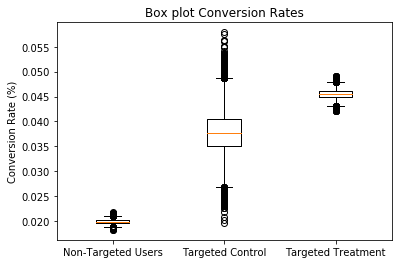

In [6]:
fig_bp, ax_bp = plt.subplots()
ax_bp.set_title('Box plot Conversion Rates')
ax_bp.boxplot([theta_n_samples*100,theta_d0_samples*100,theta_d1_samples*100])
plt.xticks([1, 2, 3], ['Non-Targeted Users','Targeted Control', 'Targeted Treatment'])
ax_bp.set_ylabel('Conversion Rate (%)')

plt.show()

Huge user **selection bias** performed by the targeting engine. Conversion rate of non-targeted users versus conversion rate of targeted users in control is close to **2X**. 

Campaign lift (%) on the exposed users 90% credible interval:  [ 1.93622979 20.74702819 46.33428431]


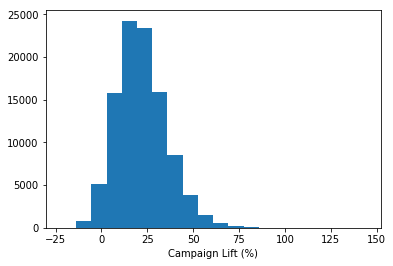

Campaign incremental converters as % of the converters observed in treatment population 90% credible interval:  [ 0.98003563  8.95311913 16.60459424]


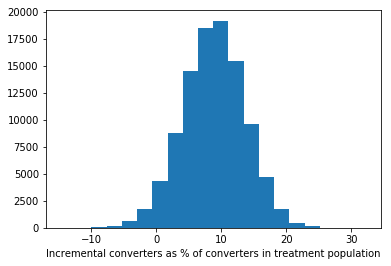

In [7]:
# Lift based on user exposed population
lift_perc = 100*(theta_d1_samples-theta_d0_samples)/theta_d0_samples
CI_lift = np.percentile(lift_perc,[5,50,95])
print('Campaign lift (%) on the exposed users 90% credible interval: ',CI_lift)

fig, ax = plt.subplots()
n, bins, patches = ax.hist(lift_perc, 20)
ax.set_xlabel('Campaign Lift (%)')

plt.show()

# Incremental conversions
ATTR_samp = 100*(theta_d1_samples-theta_d0_samples)*sum(in_counts[4:5])/(in_counts[5]+in_counts[3])
CI_ATTR = np.percentile(ATTR_samp,[5,50,95])
print('Campaign incremental converters as % of the converters observed in treatment population 90% credible interval: ',CI_ATTR)

fig, ax = plt.subplots()
n, bins, patches = ax.hist(ATTR_samp, 20)
ax.set_xlabel('Incremental converters as % of converters in treatment population')

plt.show()

## References and additional reading in treatment evaluation

A broader generalization for the case of experiments with non-compliance is **Principal Stratification** where the individuals are segmented based on the individual response in both treatment groups. Since we never observe a given individual in both groups, the causal inference problem becomes a missing value problem. 

Some References:

* [Introductory Slides with intrumental variables](https://www2.stat.duke.edu/courses/Spring14/sta320.01/IV_noncompliance.pdf)

* [Bayesian Estimator Discussed here](https://scholar.harvard.edu/files/imbens/files/bayesian_inference_for_causal_effects_in_randomized_experiments_with_noncompliance.pdf). 

* [Application to Campaign Evaluation](http://alumni.soe.ucsc.edu/~jbarajas/publications/paper_MarketingScience.pdf). Results replicated in this notebook.

* [Principal Stratification Modeling Examples (slides)](https://www2.stat.duke.edu/courses/Spring14/sta320.01/principalstratification.pdf)